# Loss Inference

Examples on how to use the `ann_inference` package to gain a deeper understanding of neural networks. To begin I'll load the `arrow_helper.py` file into memory so I can use a few of the builtin methods to work with `Parquet` tables that have been written to disk on my system.

In [5]:
import sys
sys.path.append('..')

import ann_inference.data.arrow_helper as ah
import ann_inference.sample.boot as boot
import matplotlib.pyplot as plt
import numpy as np

Iterations of a simple feedforward neural network were run and the column averages of the model weights were computed over each epoch. The Apache `Arrow` project and specifically the `Parquet` format were leveraged heavily to incrementally write the results to disk. The incremental writes of model coefficients allowed for minimal impact on in-memory processing. In addition, the columnar nature as well as the efficient IO operations enabled by the `Arrow` project allowed for inference to be performed on the model as a product of training as opposed to designing additional training steps solely for inference purposes. For more information on the `Arrow` project or the `Parquet` format as utilized in the `ann_inference` package please see either the `pyarrow` documentation: [pyarrow](https://arrow.apache.org/docs/python/) or the `Arrow` homepage: [Apache Arrow](https://arrow.apache.org/).

Parquet files on disk can be read into a variety of powerful analytic engines including: `Spark`, `Drill`, and `Pandas DataFrames`. I will focus on Pandas as the files I will be working with are written on local disk but they could just have easily been added to hdfs or similar and processed.

Reading files into memory in the form of a `DataFrame` is as simple as calling `read_parquet_store(path, nthreads=5)` on a directory where the `fit` or `gen_test_datasets` methods have been pointed to. Note that in addition to the path users can specify the number of threads to use when reading in the table which can significantly improve IO speed.

### Reading Model Tests

In [6]:
path = '../../parquet_store/regression_tests/12_10_2018/'
loss = 'stat=mse/'

pd_loss = ah.read_parquet_store(path + loss)

In [7]:
pd_loss.head()

,id,epoch_num,mse
0,14,0,22729.007812
1,14,1,22556.705078
2,14,2,22268.392578
3,14,3,21698.453125
4,14,4,20534.787109


In [8]:
np.sort(pd_loss.id.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

From the above we can see that approximately 20 tests were run across the network. The number of observations is sufficient that we should be able to generate insight into the underlying behavior of the network at each epoch. I will focus most of my testing on the final epoch which we can easily see by calling the below.

In [9]:
pd_loss.epoch_num.max()

499

Next, I'll generate a `DataFrame` consisting of the final epoch across all tests to better understand the behavior of the network.

In [10]:
final_epoch = pd_loss[pd_loss.epoch_num==pd_loss.epoch_num.max()]

In [11]:
final_epoch.head()

,id,epoch_num,mse
499,14,499,1.998094
499,6,499,2.145966
499,1,499,2.430602
499,5,499,2.279088
499,0,499,1.825438


### Analyze Loss


Next, the weights will be converted into a __Numpy__ `ndarray` to allow bootstrap estimates of the mean and variance for the given weight to be calculated.

In [12]:
final_loss = final_epoch[final_epoch.columns[2]].values

To perform inference we need a mechanism to gather evidence about the population of interest, in this case model parameters. To do this we will leverage the percentile bootstrap for both population mean and variance over the 20 iterations of `fit`. 

Methods for calling the percentile bootstrap can be found in `boot.py` and specifically the `boot_stat` method. For 
efficiency space is preallocated before assignment for the bootstrap estimates of the model parameters.

### Bootstrap Estimates

Next, we iterate over the columns in the matrices for storing the test statistics and assign the results from `boot_stat` to each of the columns in `boot_mean` and `boot_var`.

In [13]:
boot_samples = 999
boot_mean = boot.boot_stat(final_loss, n_iter=boot_samples, test_stat=np.mean)
boot_var = boot.boot_stat(final_loss, n_iter=boot_samples)

In [14]:
mean_perc = np.percentile(boot_mean, [2.5, 50, 97.5])
var_perc = np.percentile(boot_var, [2.5, 50, 97.5])

In [15]:
mean_perc

array([ 1.99846171,  2.06682674,  2.14595661])

In [16]:
var_perc

array([ 0.01638026,  0.02771505,  0.04158632])

In [17]:
mse_epoch = np.zeros([boot_samples, len(pd_loss.epoch_num.unique())])

In [18]:
for j in np.arange(0, mse_epoch.shape[1]):
    mse_epoch[:,j] = boot.boot_stat(pd_loss[pd_loss.epoch_num==j].mse.values, n_iter=boot_samples, test_stat=np.mean)

In [19]:
mse_all = np.percentile(mse_epoch, [2.5, 50, 97.5], axis=0)

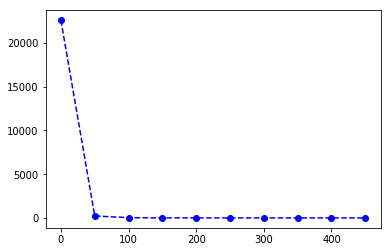

In [20]:
%matplotlib inline

plt.plot(np.arange(0, mse_all.shape[1], 50), mse_all[1,np.arange(0, mse_all.shape[1], 50)], 'b--o')
plt.show()